TPA-3: YOLOv8++ for overlap object detection from cluttered indoor shots, invariant to sensor, lighting and affine transformation

Group-1:
1.   Debanjan Guha - CE22B050
2.   Sarvesh Shanbhag - CE22B103

We have provided comments in every cell. you can run all the cells except for the cell where the head is getting trained on stationary data - we have uploaded the trained model in the google drive (100epochsbest.pt) you can directly load that.

Please do let us know if there's any issue. Thanks!

All the data is present in YOLOV8++ drive.
https://drive.google.com/drive/folders/1z78FACvcam31CxOse2aGdolgLaJXjsnV?usp=sharing






1. Custom data (augmented) is present in stationaryaug.zip - We got the base dataset from roboflow https://universe.roboflow.com/national-university-fast/stationary-items-dataset/dataset/8 and performed augmentation.

2. Ultralytics github was cloned and necessary changes were made in its architecture to add an extra head. All the edits have been added to ultralytics.zip

3. the model has been trained on custom dataset for 100 epochs using Kaggle GPU P100 (no need to train again as it might consume a lot of time) and the best.pt has been uploaded in the drive (100epochsbest.pt).

major changes in ultralytics.zip -
1. the yaml file was edited and an extra head was added - ultralytics/ultralytics/cfg/models/v8/yolov8x-2xhead.yaml
2. ConcatHead Layer was added in ultralytics/ultralytics/nn/modules/conv.py

class ConcatHead(nn.Module):
    """Concatenation layer for Detect heads."""

    def __init__(self, nc1=80, nc2=1, ch=()):
        """Initializes the ConcatHead."""
        super().__init__()
        self.nc1 = nc1  # number of classes of head 1
        self.nc2 = nc2  # number of classes of head 2

    def forward(self, x):
        """Concatenates and returns predicted bounding boxes and class probabilities."""

        # x is a list of length 2
        # Each element is either a tuple or just the decoded features
        # depending whether it's being exported.
        # First element of tuple are the decoded preds,
        # second element are feature maps for heatmap visualization

        if isinstance(x[0], tuple):
            preds1 = x[0][0]
            preds2 = x[1][0]
        elif isinstance(x[0], list): # when returned raw outputs
            # The shape is used for stride creation in tasks.py.
            # Feature maps will have to be decoded individually if used as they can't be merged.
            return [torch.cat((x0, x1), dim=1) for x0, x1 in zip(x[0], x[1])]
        else:
            preds1 = x[0]
            preds2 = x[1]

        # Concatenate the new head outputs as extra outputs

        # 1. Concatenate bbox outputs
        # Shape changes from [N, 4, 6300] to [N, 4, 12600]
        preds = torch.cat((preds1[:, :4, :], preds2[:, :4, :]), dim=2)

        # 2. Concatenate class outputs
        # Append preds 1 with empty outputs of size 6300
        shape = list(preds1.shape)
        shape[-1] = preds1.shape[-1] + preds2.shape[-1]

        preds1_extended = torch.zeros(shape, device=preds1.device,
                                      dtype=preds1.dtype)
        preds1_extended[..., : preds1.shape[-1]] = preds1

        # Prepend preds 2 with empty outputs of size 6300
        shape = list(preds2.shape)
        shape[-1] = preds1.shape[-1] + preds2.shape[-1]

        preds2_extended = torch.zeros(shape, device=preds2.device,
                                      dtype=preds2.dtype)
        preds2_extended[..., preds2.shape[-1] :] = preds2

        # Arrange the class probabilities in order preds1, preds2. The
        # class indices of preds2 will therefore start after preds1
        preds = torch.cat((preds, preds1_extended[:, 4:, :]), dim=1)
        preds = torch.cat((preds, preds2_extended[:, 4:, :]), dim=1)

        if isinstance(x[0], tuple):
            return (preds, x[0][1])
        else:
            return preds






In [1]:
#unzipping ultralytics.zip
!unzip /content/drive/MyDrive/YOLOV8++/ultralytics.zip -d /content/

Archive:  /content/drive/MyDrive/YOLOV8++/ultralytics.zip
  inflating: /content/__results___files/__results___49_0.png  
  inflating: /content/__results___files/__results___51_0.png  
  inflating: /content/__results___files/__results___52_0.png  
  inflating: /content/__results___files/__results___53_0.png  
  inflating: /content/fin.png        
  inflating: /content/ultralytics/.git/HEAD  
  inflating: /content/ultralytics/.git/ORIG_HEAD  
  inflating: /content/ultralytics/.git/config  
  inflating: /content/ultralytics/.git/description  
  inflating: /content/ultralytics/.git/hooks/applypatch-msg.sample  
  inflating: /content/ultralytics/.git/hooks/commit-msg.sample  
  inflating: /content/ultralytics/.git/hooks/fsmonitor-watchman.sample  
  inflating: /content/ultralytics/.git/hooks/post-update.sample  
  inflating: /content/ultralytics/.git/hooks/pre-applypatch.sample  
  inflating: /content/ultralytics/.git/hooks/pre-commit.sample  
  inflating: /content/ultralytics/.git/hooks/pr

In [2]:
#unzipping stationaryaug.zip
#it has stationary dataset in COCO format.
!unzip /content/drive/MyDrive/YOLOV8++/stationaryaug.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/stationary/train/images/22i1451_20_jpeg.rf.e3ed745673e856d9665a45dfe1764517.jpg  
  inflating: /content/stationary/train/images/22i1451_20_jpeg.rf.e3ed745673e856d9665a45dfe1764517_blur.jpg  
  inflating: /content/stationary/train/images/22i1451_20_jpeg.rf.e3ed745673e856d9665a45dfe1764517_gaussian.jpg  
  inflating: /content/stationary/train/images/22i1451_20_jpeg.rf.e3ed745673e856d9665a45dfe1764517_low_light.jpg  
  inflating: /content/stationary/train/images/22i1451_22_jpeg.rf.109a6d8fac2830f9e811fbd58ada1552.jpg  
  inflating: /content/stationary/train/images/22i1451_22_jpeg.rf.109a6d8fac2830f9e811fbd58ada1552_blur.jpg  
  inflating: /content/stationary/train/images/22i1451_22_jpeg.rf.109a6d8fac2830f9e811fbd58ada1552_gaussian.jpg  
  inflating: /content/stationary/train/images/22i1451_22_jpeg.rf.109a6d8fac2830f9e811fbd58ada1552_low_light.jpg  
  inflating: /content/stationary/train/images/22i1451_23_jpg.rf.213bc

In [3]:
%cd /content/ultralytics

/content/ultralytics


In [4]:
from ultralytics import YOLO
import torch
import copy

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
model = YOLO("yolov8x.pt")  # load a pretrained model

In [6]:
# Keep a copy of old state dict for sanity check
old_dict = copy.deepcopy(model.state_dict())

In [7]:
# We should freeze all but the last layer
model.state_dict().keys()

odict_keys(['model.model.0.conv.weight', 'model.model.0.bn.weight', 'model.model.0.bn.bias', 'model.model.0.bn.running_mean', 'model.model.0.bn.running_var', 'model.model.0.bn.num_batches_tracked', 'model.model.1.conv.weight', 'model.model.1.bn.weight', 'model.model.1.bn.bias', 'model.model.1.bn.running_mean', 'model.model.1.bn.running_var', 'model.model.1.bn.num_batches_tracked', 'model.model.2.cv1.conv.weight', 'model.model.2.cv1.bn.weight', 'model.model.2.cv1.bn.bias', 'model.model.2.cv1.bn.running_mean', 'model.model.2.cv1.bn.running_var', 'model.model.2.cv1.bn.num_batches_tracked', 'model.model.2.cv2.conv.weight', 'model.model.2.cv2.bn.weight', 'model.model.2.cv2.bn.bias', 'model.model.2.cv2.bn.running_mean', 'model.model.2.cv2.bn.running_var', 'model.model.2.cv2.bn.num_batches_tracked', 'model.model.2.m.0.cv1.conv.weight', 'model.model.2.m.0.cv1.bn.weight', 'model.model.2.m.0.cv1.bn.bias', 'model.model.2.m.0.cv1.bn.running_mean', 'model.model.2.m.0.cv1.bn.running_var', 'model.mod

In [8]:
# Add a callback to put the frozen layers in eval mode to prevent BN values
# from changing.
def put_in_eval_mode(trainer, n_layers=22):
  for i, (name, module) in enumerate(trainer.model.named_modules()):
    if name.endswith("bn") and int(name.split('.')[1]) < n_layers:
      module.eval()
      module.track_running_stats = False
      # print(name, " put in eval mode.")

In [9]:
model.add_callback("on_train_epoch_start", put_in_eval_mode)
model.add_callback("on_pretrain_routine_start", put_in_eval_mode)

In [ ]:
# Train (finetune) the model on stationary dataset. Freeze the first 22 layers [0-21]. basically training the head.
# NO NEED TO RUN THIS.
# We have saved the best.pt file after running this for 100 epochs. (100epochsbest.pt)
# We have loaded the file in the next code cell.
results = model.train(data='/content/stationary/data.yaml', freeze=22, epochs=100, imgsz=640)

In [10]:
#finetuned model on stationary dataset
model=YOLO("/content/drive/MyDrive/YOLOV8++/100epochsbest.pt")

In [11]:
def compare_dicts(state_dict1, state_dict2):
    # Compare the keys
    keys1 = set(state_dict1.keys())
    keys2 = set(state_dict2.keys())

    if keys1 != keys2:
        print("Models have different parameter names.")
        return False

    # Compare the values (weights)
    for key in keys1:
        if not torch.equal(state_dict1[key], state_dict2[key]):
            print(f"Weights for parameter '{key}' are different.")
            if "bn" in key and "22" not in key:
              state_dict1[key] = state_dict2[key]

In [12]:
# Compare the dicts. Changes should only be in layer 22 (head). This is the finetuned head
compare_dicts(old_dict, model.state_dict())

Weights for parameter 'model.model.22.cv2.1.0.bn.running_mean' are different.
Weights for parameter 'model.model.22.cv2.2.0.bn.bias' are different.
Weights for parameter 'model.model.22.cv2.2.1.bn.running_var' are different.
Weights for parameter 'model.model.22.cv3.2.2.weight' are different.
Weights for parameter 'model.model.22.cv2.2.1.bn.bias' are different.
Weights for parameter 'model.model.22.cv3.0.1.bn.num_batches_tracked' are different.
Weights for parameter 'model.model.22.cv3.0.1.conv.weight' are different.
Weights for parameter 'model.model.22.cv3.0.0.bn.weight' are different.
Weights for parameter 'model.model.22.cv3.2.1.bn.weight' are different.
Weights for parameter 'model.model.22.cv2.0.1.bn.num_batches_tracked' are different.
Weights for parameter 'model.model.22.cv2.1.1.bn.bias' are different.
Weights for parameter 'model.model.22.cv2.1.0.bn.bias' are different.
Weights for parameter 'model.model.22.cv2.2.1.bn.running_mean' are different.
Weights for parameter 'model.m

In [13]:
new_state_dict = dict()

In [14]:
#  Increment the head number by 1 in the state_dict. So that it becomes layer 23 (Additional Head)
for k, v in model.state_dict().items():
  if k.startswith("model.model.22"):
    new_state_dict[k.replace("model.22", "model.23")] = v

In [15]:
# Save the current state_dict
torch.save(new_state_dict, "yolov8xfin.pth")

# Create new architecture with extra head and load custom weights

In [16]:
from ultralytics import YOLO
import torch

In [17]:
#this yaml has 2 heads. loading pretrained YOLOv8x on this new architecture to initialize layers 0-22 (backbone + pretrained head).
model_2 = YOLO('ultralytics/cfg/models/v8/yolov8x-2xhead.yaml', task="detect").load('yolov8x.pt')

Transferred 595/680 items from pretrained weights


In [18]:
model_2.state_dict().keys()

odict_keys(['model.model.0.conv.weight', 'model.model.0.bn.weight', 'model.model.0.bn.bias', 'model.model.0.bn.running_mean', 'model.model.0.bn.running_var', 'model.model.0.bn.num_batches_tracked', 'model.model.1.conv.weight', 'model.model.1.bn.weight', 'model.model.1.bn.bias', 'model.model.1.bn.running_mean', 'model.model.1.bn.running_var', 'model.model.1.bn.num_batches_tracked', 'model.model.2.cv1.conv.weight', 'model.model.2.cv1.bn.weight', 'model.model.2.cv1.bn.bias', 'model.model.2.cv1.bn.running_mean', 'model.model.2.cv1.bn.running_var', 'model.model.2.cv1.bn.num_batches_tracked', 'model.model.2.cv2.conv.weight', 'model.model.2.cv2.bn.weight', 'model.model.2.cv2.bn.bias', 'model.model.2.cv2.bn.running_mean', 'model.model.2.cv2.bn.running_var', 'model.model.2.cv2.bn.num_batches_tracked', 'model.model.2.m.0.cv1.conv.weight', 'model.model.2.m.0.cv1.bn.weight', 'model.model.2.m.0.cv1.bn.bias', 'model.model.2.m.0.cv1.bn.running_mean', 'model.model.2.m.0.cv1.bn.running_var', 'model.mod

In [20]:
#loading the finetuned head (layer 23) in the dictionary
state_dict = torch.load("yolov8xfin.pth")


In [21]:
state_dict.keys()

dict_keys(['model.model.23.cv2.0.0.conv.weight', 'model.model.23.cv2.0.0.bn.weight', 'model.model.23.cv2.0.0.bn.bias', 'model.model.23.cv2.0.0.bn.running_mean', 'model.model.23.cv2.0.0.bn.running_var', 'model.model.23.cv2.0.0.bn.num_batches_tracked', 'model.model.23.cv2.0.1.conv.weight', 'model.model.23.cv2.0.1.bn.weight', 'model.model.23.cv2.0.1.bn.bias', 'model.model.23.cv2.0.1.bn.running_mean', 'model.model.23.cv2.0.1.bn.running_var', 'model.model.23.cv2.0.1.bn.num_batches_tracked', 'model.model.23.cv2.0.2.weight', 'model.model.23.cv2.0.2.bias', 'model.model.23.cv2.1.0.conv.weight', 'model.model.23.cv2.1.0.bn.weight', 'model.model.23.cv2.1.0.bn.bias', 'model.model.23.cv2.1.0.bn.running_mean', 'model.model.23.cv2.1.0.bn.running_var', 'model.model.23.cv2.1.0.bn.num_batches_tracked', 'model.model.23.cv2.1.1.conv.weight', 'model.model.23.cv2.1.1.bn.weight', 'model.model.23.cv2.1.1.bn.bias', 'model.model.23.cv2.1.1.bn.running_mean', 'model.model.23.cv2.1.1.bn.running_var', 'model.model.2

In [22]:
# Load state_dict of the custom trained model head. Layer 23.
model_2.load_state_dict(state_dict, strict=False)

_IncompatibleKeys(missing_keys=['model.model.0.conv.weight', 'model.model.0.bn.weight', 'model.model.0.bn.bias', 'model.model.0.bn.running_mean', 'model.model.0.bn.running_var', 'model.model.1.conv.weight', 'model.model.1.bn.weight', 'model.model.1.bn.bias', 'model.model.1.bn.running_mean', 'model.model.1.bn.running_var', 'model.model.2.cv1.conv.weight', 'model.model.2.cv1.bn.weight', 'model.model.2.cv1.bn.bias', 'model.model.2.cv1.bn.running_mean', 'model.model.2.cv1.bn.running_var', 'model.model.2.cv2.conv.weight', 'model.model.2.cv2.bn.weight', 'model.model.2.cv2.bn.bias', 'model.model.2.cv2.bn.running_mean', 'model.model.2.cv2.bn.running_var', 'model.model.2.m.0.cv1.conv.weight', 'model.model.2.m.0.cv1.bn.weight', 'model.model.2.m.0.cv1.bn.bias', 'model.model.2.m.0.cv1.bn.running_mean', 'model.model.2.m.0.cv1.bn.running_var', 'model.model.2.m.0.cv2.conv.weight', 'model.model.2.m.0.cv2.bn.weight', 'model.model.2.m.0.cv2.bn.bias', 'model.model.2.m.0.cv2.bn.running_mean', 'model.model

In [23]:
test_image="/content/drive/MyDrive/YOLOV8++/testimage.jpg"

In [24]:
# Output of COCO model
coco_class_names = [
    "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat", "traffic light",
    "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow",
    "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee",
    "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple",
    "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "couch",
    "potted plant", "bed", "dining table", "toilet", "TV", "laptop", "mouse", "remote", "keyboard", "cell phone",
    "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors", "teddy bear",
    "hair drier", "toothbrush", 'ball point', 'book', 'eraser', 'notebook', 'pencil', 'pointer', 'scale', 'sharpener'
]


model_coco = YOLO("yolov8x.pt")

# For consistency
model_coco.model.names = {i: name for i, name in enumerate(coco_class_names)}

result_coco = model_coco.predict(test_image)[0]


image 1/1 /content/drive/MyDrive/YOLOV8++/testimage.jpg: 480x640 2 laptops, 1 mouse, 2 keyboards, 118.1ms
Speed: 13.1ms preprocess, 118.1ms inference, 845.2ms postprocess per image at shape (1, 3, 480, 640)


In [25]:
# Output of custom model
model_custom = YOLO("/content/drive/MyDrive/YOLOV8++/100epochsbest.pt")

# For plotting consistency, change all class names to class numbers
# model_lp.model.names = {k:k for k in model_lp.names.keys()}
import yaml
with open('/content/stationary/data.yaml', 'r') as f:
    lp_data = yaml.safe_load(f)
model_custom.model.names = {i: name for i, name in enumerate(lp_data['names'])}

result_custom = model_custom.predict(test_image)[0]


image 1/1 /content/drive/MyDrive/YOLOV8++/testimage.jpg: 480x640 1 ball point, 1 eraser, 2 notebooks, 74.7ms
Speed: 2.1ms preprocess, 74.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


In [26]:
#output of the merged model

# Define the correct class names manually
custom_class_names = [
    "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat", "traffic light",
    "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow",
    "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee",
    "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple",
    "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "couch",
    "potted plant", "bed", "dining table", "toilet", "TV", "laptop", "mouse", "remote", "keyboard", "cell phone",
    "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors", "teddy bear",
    "hair drier", "toothbrush", 'ball point', 'book', 'eraser', 'notebook', 'pencil', 'pointer', 'scale', 'sharpener'
]

# Assign the custom class names to the model
model_2.model.names = {i: name for i, name in enumerate(custom_class_names)}

# Generate predictions of merged model
result_merged = model_2.predict(test_image)[0]


image 1/1 /content/drive/MyDrive/YOLOV8++/testimage.jpg: 480x640 2 laptops, 1 mouse, 2 keyboards, 1 ball point, 1 eraser, 2 notebooks, 86.5ms
Speed: 2.0ms preprocess, 86.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


In [27]:
import matplotlib.pyplot as plt
import numpy as np

In [28]:
def show_output(images):
    image = np.vstack(images)
    fig = plt.figure()
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    fig.set_size_inches((5,15))
    ax.imshow(image[...,::-1])

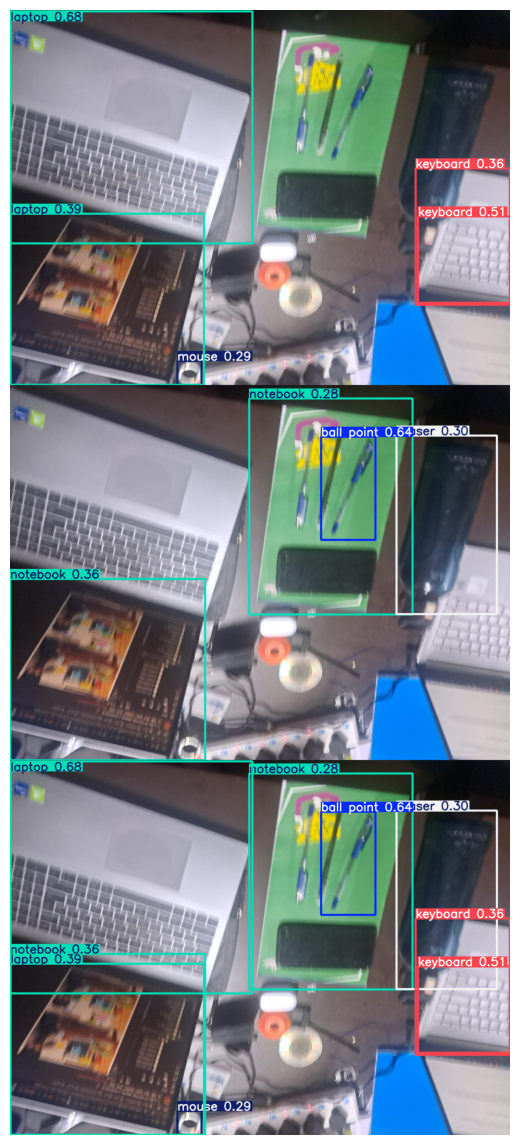

In [29]:
show_output([result_coco.plot(), result_custom.plot(), result_merged.plot()])